# Denoising Signals

In [1]:
# import all necessary modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend
import pandas as pd
import copy

# Smoothing via running-mean filter

Time length= 10001


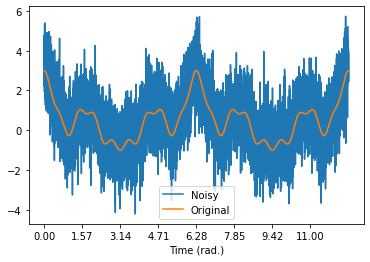

In [2]:
# create a noisy signal

N = 10001
time = np.linspace(0,4*np.pi,N)
print('Time length=', len(time))
signal = np.zeros(N)
for i in range(1,4):
    signal += np.cos(i*time)**i

noisysignal = signal + np.random.randn(N)

plt.plot(time,noisysignal, time,signal)
plt.legend(['Noisy','Original'])
plt.xlabel('Time (rad.)')
plt.xticks(np.arange(time[0],time[-1],np.pi/2))
plt.show()

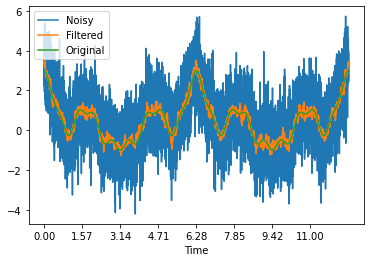

In [3]:
k = 15

filtsignal = copy.deepcopy(noisysignal)

for i in range(N):
    start = np.max((0,i-k))
    stop = np.min((N,i+k))
    filtsignal[i] = np.mean(noisysignal[start:stop])


# and plot
plt.plot( time, noisysignal,time,filtsignal, time,signal)
plt.legend(['Noisy','Filtered','Original'], loc='upper left')
plt.xlabel('Time')
plt.xticks(np.arange(time[0],time[-1],np.pi/2))
plt.show()

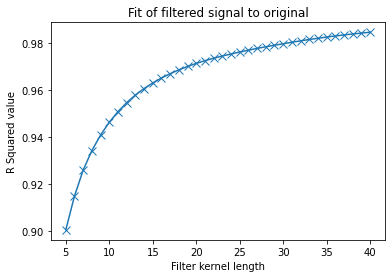

In [4]:
# mean-smoothing function, to be called later
def meansmooth(signalIn,k):
    filtsignal = copy.deepcopy(signalIn)
    N = len(signalIn)
    for i in range(N):
        filtsignal[i] = np.mean(signalIn[ np.max((0,i-k)) : np.min((N,i+k)) ])
    return filtsignal


# range of smoothing kernels
kvals = np.arange(5,41) 
signalCorrs = []

for ki in kvals:
    filtered_signal = meansmooth(noisysignal,ki)
    corr = np.corrcoef(filtered_signal,signal)[0,1]**2
    signalCorrs.append(corr)
    

plt.plot(kvals,signalCorrs,'x-',markerfacecolor='w',markersize=8)
plt.title('Fit of filtered signal to original')
plt.xlabel('Filter kernel length')
plt.ylabel('R Squared value')
plt.show()

# Smoothing via Gaussian convolution

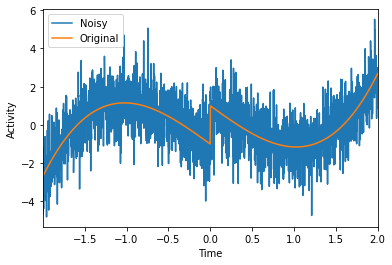

In [5]:
# create signal
srate = 512
time  = np.arange(-2,2+1/srate,1/srate)
points  = len(time)

signal = detrend(time**3 + np.sign(time))
noisysignal = signal + np.random.randn(points)*1.1

plt.plot(time,noisysignal, time,signal)
plt.xlabel('Time')
plt.ylabel('Activity')
plt.legend(['Noisy','Original'])
plt.xlim(time[[1,-1]])
plt.show()

# Gaussian Kernel

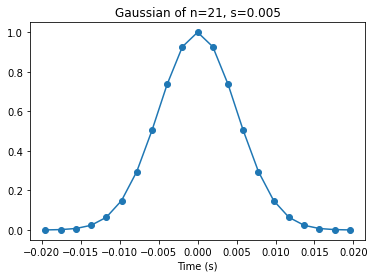

'The ends of the Gaussian kernal go off to infinite'

In [6]:
k = 10
x = np.arange(-k,k+1)/srate
s = .005
gaussian = np.exp(-x**2 / (2*s**2))

plt.plot(x,gaussian,'o-')
plt.title('Gaussian of n=%g, s=%g'%(2*k+1,s))
plt.xlabel('Time (s)')
plt.show()
display('The ends of the Gaussian kernal go off to infinite')

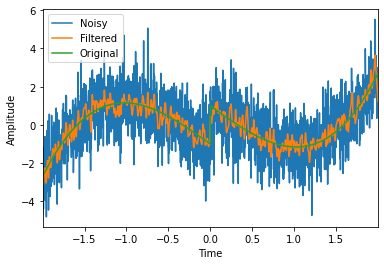

'Filtered vs original r2=0.8681847234329744'

'Noisy vs original r2=0.4398584841502896'

The filtered signal has removed a good level of noise


In [7]:
# run convolution
gaussian = gaussian / sum(gaussian) # normalise
filtered = np.convolve(noisysignal,gaussian,mode='same') #filter noisy signal with gaussian kernel.

# Compareing Noisy, filtered and Original signals
plt.plot(time,noisysignal, time,filtered, time,signal)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(['Noisy','Filtered','Original'], loc='upper left')
plt.xlim(time[[2,-2]])
plt.show()

filtered_r2 = np.corrcoef(filtered, signal)[0,1]**2
noisy_r2 = np.corrcoef(noisysignal, signal)[0,1]**2
display('Filtered vs original r2={}'.format(filtered_r2))
display('Noisy vs original r2={}'.format(noisy_r2))
print( 'The filtered signal has removed a good level of noise')

## Different parameter sizes effects on Gaussian kernel shape

In [8]:
# length vs. width of kernel

# parameter ranges
krange = np.arange(3,300,20)
srange = np.linspace(.001,.5,60)

# initialize
sseMat = np.zeros((len(krange),len(srange)))
allkernels = [[0]*len(srange) for i in range(len(krange))]

for ki in range(len(krange)):
    for si in range(len(srange)):
        x = np.arange(-krange[ki],krange[ki]+1)/srate
        s = srange[si]
        gkern = np.exp(-x**2 / (2*s**2)) # create Gaussian

    # filter the signal
        filtsig = np.convolve(noisysignal,gkern/sum(gkern),mode='same')
    
    # compute Squared Sum Error (SSE)
        sseMat[ki,si] = np.sum((filtsig-signal)**2)
    
    # store Gaussians for later
        allkernels[ki][si] = gkern


K=length of kernel and Sigma is the width of bell shape


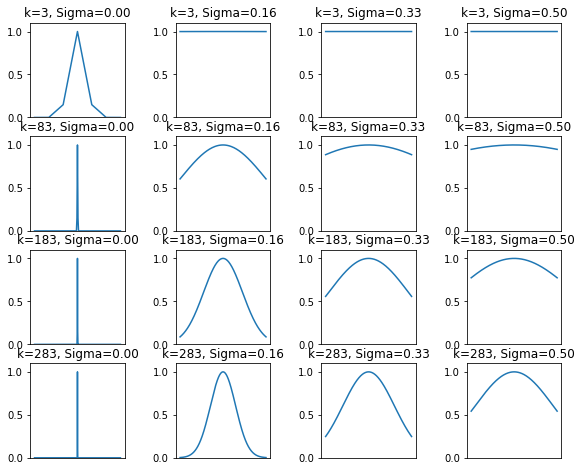

In [9]:
fig,ax = plt.subplots(4,4,figsize=(10,8))
sidx = np.linspace(0,len(srange)-1,4).astype(int)
kidx = np.linspace(0,len(krange)-1,4).astype(int)
print('K=length of kernel and Sigma is the width of bell shape')
for si in range(4):
    for kj in range(4):
        ax[kj,si].plot(allkernels[kidx[kj]][sidx[si]])
        ax[kj,si].set_xticks([])
        ax[kj,si].set_ylim([0,1.1])
        ax[kj,si].set_title('k=%g, Sigma=%.2f'%(krange[kidx[kj]],srange[sidx[si]]))
        ax[kj,si].set_aspect(1/ax[kj,si].get_data_ratio())

plt.show()

# Transient noise filtering via median filter

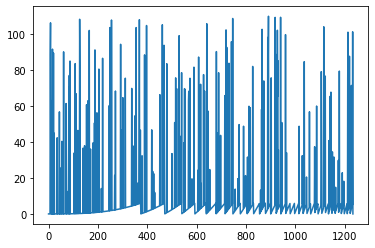

In [10]:
# create the signal with transient noise

points = 1234
signal = np.mod(np.linspace(0,6,points)**3,6)
orig_signal = signal.copy()
# add transient noise
b = int(.15*len(signal))
spiketimes = np.random.randint(0,len(signal),b)

signal[spiketimes] = 11 + 100*np.random.rand(b)

plt.plot(signal)
plt.show()

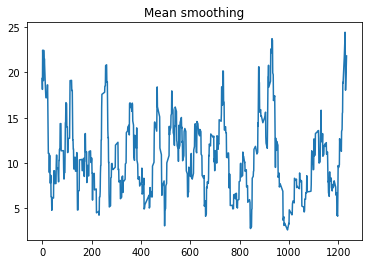

In [11]:
# try mean-smoothing
k = 15
mean_filtered = signal.copy()
for i in range(points):
    start = np.max((0,i-k))
    stop = np.min((points,i+k))
    mean_filtered[i] = np.mean(signal[start:stop])

# and plot
plt.plot(mean_filtered)
plt.title('Mean smoothing')
plt.show()

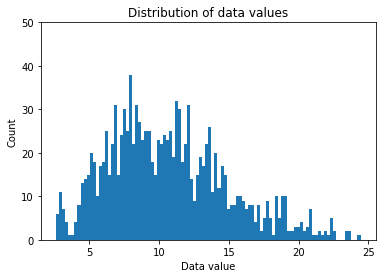

mean count =12.34


In [12]:
# find a threshold for unusually large values

plt.hist(mean_filtered,100)
plt.ylim([0,50])
plt.xlabel('Data value')
plt.ylabel('Count')
plt.title('Distribution of data values')
plt.show()
thresh= np.mean(np.histogram(mean_filtered,bins=100)[0])
print('mean count ='+ str(thresh))

In [13]:
# threshold
thresh = int(thresh)

# find locations of above the threshold
threshpoints = np.where(signal>thresh)[0]
print(threshpoints)
print(100*len(threshpoints)/points)

[   7    8    9   13   16   20   23   35   44   49   50   54   61   71
   72   74   82   84   87  104  107  108  110  112  119  126  127  140
  146  154  160  165  170  181  186  188  196  204  214  219  246  249
  250  251  253  255  256  268  271  292  295  301  311  337  341  342
  351  355  361  367  368  372  379  389  397  418  422  426  451  461
  468  469  479  480  500  511  515  519  529  531  536  539  549  551
  553  567  568  573  581  589  605  608  616  618  628  632  641  646
  653  680  683  688  689  691  697  714  719  722  728  731  740  741
  746  756  767  772  790  798  806  812  817  827  859  863  865  870
  872  888  890  891  902  918  921  927  928  929  931  940  945  960
  964 1015 1028 1036 1045 1057 1078 1082 1086 1104 1105 1106 1115 1121
 1136 1141 1142 1144 1150 1156 1163 1174 1178 1190 1196 1212 1213 1219
 1227 1230 1232]
13.857374392220422


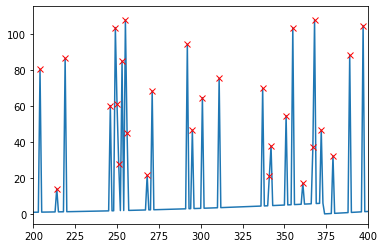

In [14]:
# let's see what it looks like
plt.plot(signal)
plt.plot(threshpoints,signal[threshpoints],'rx')

# zoom in
plt.xlim([200,400])
plt.show()

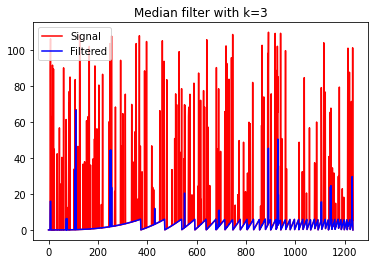

filtered and original r2=0.12650008888550973
Noisy and original signal r2 =0.0028949140282299355


In [15]:
# apply median filter

k = 3 # filter size
filtered = signal.copy()

for i in threshpoints:
    start = np.max((0,i-k))
    stop = np.min((points,i+k))
    filtered[i] = np.median(signal[start:stop])

plt.plot(signal, color='red', label='Signal')
plt.plot(filtered, color='blue', label='Filtered')
plt.legend(loc='upper left')
plt.title('Median filter with k=' + str(k))
plt.show()
filtered_r2 = np.corrcoef(filtered,orig_signal)[0,1] **2
noise_r2= np.corrcoef(signal,orig_signal)[0,1] **2
print('filtered and original r2=' + str(filtered_r2))
print('Noisy and original signal r2 =' + str(noise_r2) )

# Denoise Signals 

In [16]:
# import data
import pandas as pd
df = pd.read_csv('signals.csv' ,names=['noisy','orig'])
df.head()

,noisy,orig
0,920.23,963
1,929.06,987
2,1116.60,1024
3,1073.60,1073
4,1070.60,1134


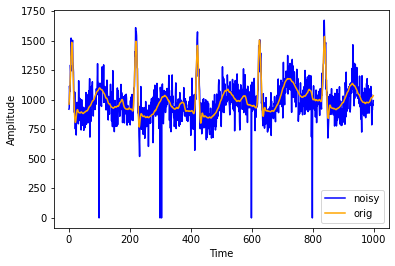

In [17]:
# plot the data
df[['noisy','orig']].plot(linewidth=1.5, color=['Blue', 'orange'])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [18]:
# create new column for filtering based on noisy data column
df['filtered'] = copy.deepcopy(df['noisy'])
display(df.describe())
display(df.head())

,noisy,orig,filtered
count,1000.000000,1000.000000,1000.000000
mean,985.426920,996.317000,985.426920
std,172.516155,120.001404,172.516155
min,0.000000,769.000000,0.000000
25%,886.312500,920.000000,886.312500
50%,970.500000,977.000000,970.500000
75%,1073.450000,1041.250000,1073.450000
max,1673.000000,1536.000000,1673.000000


,noisy,orig,filtered
0,920.23,963,920.23
1,929.06,987,929.06
2,1116.60,1024,1116.60
3,1073.60,1073,1073.60
4,1070.60,1134,1070.60


# Median Filter low values

In [27]:
# threshold
thresh = int(df['noisy'].std()*2) # capture 95%
display('Threshold ='+ str(thresh))
# find all data points above threshold
threshpoints = np.where(df['noisy']<thresh)[0]

# apply median filter
k = 7
for i in threshpoints:
    start = np.max((0,i-k))
    stop = np.min((len(df),i+k))
    df['filtered'].loc[i] = np.median(df.loc[start:stop, ('noisy')]) 


'Threshold =345'

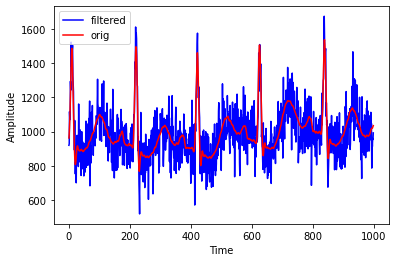

In [20]:
# plot the data
df[['filtered','orig']].plot(color=['Blue', 'red'])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [26]:
# now for a mean-smoothing filter
k = 5

for i in range(len(df)):
    start = np.max((0,i-k))
    stop = np.min((len(df),i+k))
    df['filtered'].iloc[i] = np.mean(df['noisy'].loc[start:stop])


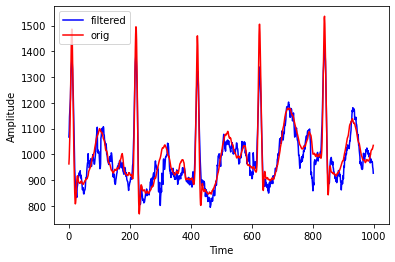

filtered and original r2=0.8573237906289931
Noisy and original signal r2 =0.48893014492481857
Filtered signal is closer to the original signal after taking out some of the noise.


In [22]:
# plot the data
df[['filtered','orig']].plot(color=['blue','red'])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(loc='upper left')
plt.show()
filtered_r2 = np.corrcoef(df['filtered'],df['orig'])[0,1] **2
noise_r2= np.corrcoef(df['noisy'],df['orig'])[0,1] **2
print('filtered and original r2=' + str(filtered_r2))
print('Noisy and original signal r2 =' + str(noise_r2) )
print('Filtered signal is closer to the original signal after taking out some of the noise.')